In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk , string

import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

nltk.download('wordnet')

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [4]:
df.shape

(404351, 6)

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.drop(['id','qid1','qid2'],axis=1,inplace=True)

In [7]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
0    0.630752
1    0.369248
Name: proportion, dtype: float64

In [8]:
df['is_duplicate'].value_counts()

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

In [9]:
df = pd.concat([df[df['is_duplicate'] == 1].sample(frac = 0.1) ,df[df['is_duplicate'] == 0].sample(frac = 0.05)],axis=0).sample(frac=1)

In [10]:
df.shape

(27683, 5)

In [11]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
1    0.539356
0    0.460644
Name: proportion, dtype: float64

<Axes: xlabel='is_duplicate'>

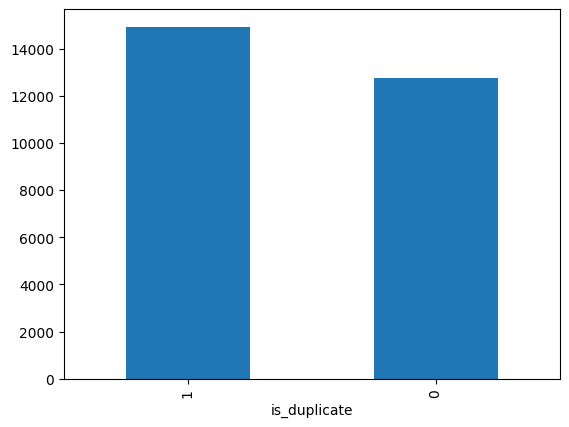

In [12]:
df['is_duplicate'].value_counts().plot(kind='bar')

**The dataset is imbalanced**  
But as the adatset is large , we can handle this by splitting dataset in a stratified fashion

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27683 entries, 369024 to 242316
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          27683 non-null  int64 
 1   qid2          27683 non-null  int64 
 2   question1     27683 non-null  object
 3   question2     27683 non-null  object
 4   is_duplicate  27683 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ MB


In [14]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [17]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.duplicated()
print('Number of questions getting repeated : ',x.sum())

Number of unique questions :  55211
Number of questions getting repeated :  155


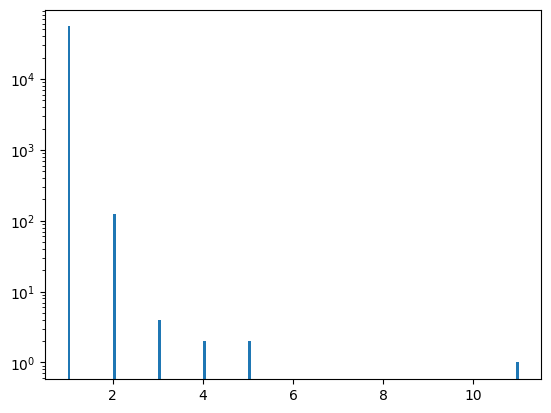

In [18]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [19]:
df.sample(20)

,qid1,qid2,question1,question2,is_duplicate
304763,598421,598422,How much time does it take to lose weight by d...,How much time does it take to lose weight doin...,1
108382,214944,214945,Which is the best digital marketing company in...,Which are the top digital marketing companies ...,1
369366,722851,722852,Is masturbating without ejaculating harmful?,How harmful or unhealthy is masturbation?,0
76831,152659,152660,What are the best laptops to buy within Rs.300...,Which laptop is best to buy within the range o...,1
109724,217581,217582,Why do we get our brightest ideas in the shower?,Why do ideas come to me so easily when I am ta...,1
247889,488124,488125,Why can't liquids be compressed?,Can any liquids be compressed?,0
336849,660403,660404,What languages and frameworks are used to code?,What languages and frameworks are used to code...,0
360537,705935,705936,How can buy an RS gold without PayPal for DK &...,How does it work to invest in gold without act...,0
317047,622132,622133,"I want to be a billionaire, how do I accomplis...",I want to become a billionaire through creatin...,1
344766,675660,675661,How do you get hard copies of your AWS certifi...,The Google Cloud platform is quite different f...,0


### Steps for going ahead with the data :

1. Preprocessing
    * Remove Punctuation
    * Remove stopwords
    * Remove contractions


In [20]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [21]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [22]:
df.head(20)

,qid1,qid2,question1,question2,is_duplicate
369024,722197,722198,when did you find the purpose of life,how do you find your life s purpose,0
347975,681798,681799,why did rbi introduce 2k rupee notes,why is the rbi issuing 2k rupee notes,1
369247,722621,722622,what s the strangest feeling you ve ever had a...,what is the strangest or unexplainable experie...,0
112605,223258,223259,what are the functions of a resistor,what is the function of a resistor,1
86394,171573,171574,how do i pick a product to sell online,how do i choose products to sell online,1
155395,307324,307325,how will trump s presidency affect indian stud...,how would it affect indian students studying w...,1
297376,584110,4915,how can i see who asked an anonymous question ...,is it possible to see when a quora question wa...,0
150929,298565,298566,is it possible to download movies from netflix,is there a way to download netflix movies onto...,1
74323,147695,147696,does education make a person better at making ...,how do i make a rational decision under emotio...,0
50955,79222,101416,do any professional musicians use fl studio,what hip hop producers use fl studio aka frui...,0


In [23]:
df['q1_len'] = df['question1'].apply(lambda x : len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x : len(x.split()))

In [24]:
df['q1_num_words'] = df['question1'].apply(lambda x : len(x.split(' ')))
df['q2_num_words'] = df['question2'].apply(lambda x : len(x.split(' ')))

In [25]:
def common_words(row):
    
    w1 = set(row['question1'].split(' '))
    w2 = set(row['question2'].split(' '))
    
    return len(w1 & w2)
    

In [26]:
df['common_words'] = df.apply(common_words, axis=1)

In [27]:
df.head(10)

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words
369024,722197,722198,when did you find the purpose of life,how do you find your life s purpose,0,8,8,8,8,4
347975,681798,681799,why did rbi introduce 2k rupee notes,why is the rbi issuing 2k rupee notes,1,7,8,7,8,5
369247,722621,722622,what s the strangest feeling you ve ever had a...,what is the strangest or unexplainable experie...,0,13,11,13,11,6
112605,223258,223259,what are the functions of a resistor,what is the function of a resistor,1,7,7,7,7,5
86394,171573,171574,how do i pick a product to sell online,how do i choose products to sell online,1,9,8,9,8,6
155395,307324,307325,how will trump s presidency affect indian stud...,how would it affect indian students studying w...,1,18,16,18,16,8
297376,584110,4915,how can i see who asked an anonymous question ...,is it possible to see when a quora question wa...,0,11,15,11,15,5
150929,298565,298566,is it possible to download movies from netflix,is there a way to download netflix movies onto...,1,8,11,8,11,5
74323,147695,147696,does education make a person better at making ...,how do i make a rational decision under emotio...,0,12,10,12,10,3
50955,79222,101416,do any professional musicians use fl studio,what hip hop producers use fl studio aka frui...,0,7,10,7,11,3


In [28]:
def total_words(row):
    
    w1 = len(row['question1'].split(' '))
    w2 = len(row['question2'].split(' '))
    
    return w1 + w2

In [29]:
df['total_words'] = df.apply(total_words, axis=1)

In [30]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [31]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0] * 8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
        return token_features
    
    # Non stopwords
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Stopwords
    
    q1_stopwords = set([word for word in q1_tokens if word  in STOP_WORDS])
    q2_stopwords = set([word for word in q2_tokens if word  in STOP_WORDS])
    
    
    # Common Word Count
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Common Stopword Count
    
    common_stopword_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common Tokens from Question pair
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words) , len(q2_words))+ SAFE_DIV) 
    token_features[1] = common_word_count / (max(len(q1_words) , len(q2_words))+ SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens) , len(q2_tokens))+ SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens) , len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    
    return token_features
    
    
    

In [32]:
token_features = df.apply(fetch_token_features,axis=1)

df['cwc_min'] = list(map(lambda x : x[0] , token_features))
df['cwc_max'] = list(map(lambda x : x[1] , token_features))
df['csc_min'] = list(map(lambda x : x[2] , token_features))
df['csc_max'] = list(map(lambda x : x[3] , token_features))
df['ctc_min'] = list(map(lambda x : x[4] , token_features))
df['ctc_max'] = list(map(lambda x : x[5] , token_features))
df['last_word_eq'] = list(map(lambda x : x[6] , token_features))
df['first_word_eq'] = list(map(lambda x : x[7] , token_features))

In [33]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
369024,722197,722198,when did you find the purpose of life,how do you find your life s purpose,0,8,8,8,8,4,16,0.25,0.999967,0.999967,0.199996,0.199996,0.499994,0.499994,0.0,0.0
347975,681798,681799,why did rbi introduce 2k rupee notes,why is the rbi issuing 2k rupee notes,1,7,8,7,8,5,15,0.33,0.799984,0.799984,0.499975,0.333322,0.714276,0.624992,1.0,1.0
369247,722621,722622,what s the strangest feeling you ve ever had a...,what is the strangest or unexplainable experie...,0,13,11,13,11,6,24,0.25,0.499988,0.499988,0.571420,0.499994,0.545450,0.461535,0.0,1.0
112605,223258,223259,what are the functions of a resistor,what is the function of a resistor,1,7,7,7,7,5,14,0.36,0.499975,0.499975,0.799984,0.799984,0.714276,0.714276,1.0,1.0
86394,171573,171574,how do i pick a product to sell online,how do i choose products to sell online,1,9,8,9,8,6,17,0.35,0.499988,0.499988,0.999975,0.799984,0.749991,0.666659,1.0,1.0


In [34]:
! pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=16d776614a3f81945b6544f3a6c288b2e11960034aa0ccc5c5bebde3ddf4dcc3
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [35]:

import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1) if strs else 0
    
    return length_features
    

In [36]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [37]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
369024,722197,722198,when did you find the purpose of life,how do you find your life s purpose,0,8,8,8,8,4,...,0.999967,0.199996,0.199996,0.499994,0.499994,0.0,0.0,0.0,8.0,0.277778
347975,681798,681799,why did rbi introduce 2k rupee notes,why is the rbi issuing 2k rupee notes,1,7,8,7,8,5,...,0.799984,0.499975,0.333322,0.714276,0.624992,1.0,1.0,1.0,7.5,0.405405
369247,722621,722622,what s the strangest feeling you ve ever had a...,what is the strangest or unexplainable experie...,0,13,11,13,11,6,...,0.499988,0.571420,0.499994,0.545450,0.461535,0.0,1.0,2.0,12.0,0.238806
112605,223258,223259,what are the functions of a resistor,what is the function of a resistor,1,7,7,7,7,5,...,0.499975,0.799984,0.799984,0.714276,0.714276,1.0,1.0,0.0,7.0,0.400000
86394,171573,171574,how do i pick a product to sell online,how do i choose products to sell online,1,9,8,9,8,6,...,0.499988,0.999975,0.799984,0.749991,0.666659,1.0,1.0,1.0,8.5,0.384615


In [38]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [40]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
369024,722197,722198,when did you find the purpose of life,how do you find your life s purpose,0,8,8,8,8,4,...,0.499994,0.0,0.0,0.0,8.0,0.277778,61,63,67,75
347975,681798,681799,why did rbi introduce 2k rupee notes,why is the rbi issuing 2k rupee notes,1,7,8,7,8,5,...,0.624992,1.0,1.0,1.0,7.5,0.405405,74,72,74,79
369247,722621,722622,what s the strangest feeling you ve ever had a...,what is the strangest or unexplainable experie...,0,13,11,13,11,6,...,0.461535,0.0,1.0,2.0,12.0,0.238806,62,61,63,67
112605,223258,223259,what are the functions of a resistor,what is the function of a resistor,1,7,7,7,7,5,...,0.714276,1.0,1.0,0.0,7.0,0.400000,91,88,91,91
86394,171573,171574,how do i pick a product to sell online,how do i choose products to sell online,1,9,8,9,8,6,...,0.666659,1.0,1.0,1.0,8.5,0.384615,86,84,83,86


sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# merge texts
questions = list(df['question1']) + list(df['question2'])

cv = TfidfVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [42]:
df = df.drop(['question1', 'question2'],axis=1)

final_df = pd.concat([df, pd.DataFrame(q1_arr, index=df.index), pd.DataFrame(q2_arr, index= df.index)], axis=1)
print(final_df.shape)
final_df.head()

(27683, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
369024,0,8,8,8,8,4,16,0.25,0.999967,0.999967,...,0.0,0.282220,0.0,0.0,0.352684,0.0,0.0,0.0,0.0,0.0
347975,1,7,8,7,8,5,15,0.33,0.799984,0.799984,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
369247,0,13,11,13,11,6,24,0.25,0.499988,0.499988,...,0.0,0.260426,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
112605,1,7,7,7,7,5,14,0.36,0.499975,0.499975,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
86394,1,9,8,9,8,6,17,0.35,0.499988,0.499988,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [43]:
del questions , q1_arr , q2_arr , df

In [44]:
final_df.columns = [str(i) for i in final_df.columns]
X = final_df.drop(['is_duplicate'],axis=1)
y = final_df['is_duplicate']


In [45]:
del final_df

In [46]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [47]:
y_train.value_counts()


is_duplicate
1    10407
0     8971
Name: count, dtype: int64

In [48]:
X_train.shape

(19378, 6022)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7910897049969897

In [64]:

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train.values,y_train.values)
y_pred1 = xgb.predict(X_test.values)
accuracy_score(y_test.values,y_pred1)

0.7945815773630344

In [65]:
from sklearn.metrics import confusion_matrix , classification_report

In [66]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[2463, 1318],
       [ 417, 4107]])

In [67]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[2583, 1198],
       [ 508, 4016]])

In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      3781
           1       0.76      0.91      0.83      4524

    accuracy                           0.79      8305
   macro avg       0.81      0.78      0.78      8305
weighted avg       0.80      0.79      0.79      8305



In [69]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      3781
           1       0.77      0.89      0.82      4524

    accuracy                           0.79      8305
   macro avg       0.80      0.79      0.79      8305
weighted avg       0.80      0.79      0.79      8305



In [56]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)


def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [57]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [70]:

q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of Pakistan?'
q4 = 'What is the business capital of India?'


In [73]:
xgb.predict(query_point_creator(q2,q3))

array([1])

In [74]:
xgb.predict(query_point_creator(q2,q4))

array([0])

In [75]:
xgb.predict(query_point_creator(q1,q4))

array([1])

In [76]:
xgb.predict(query_point_creator(q2,q3))

array([1])

In [84]:
xgb.predict(query_point_creator('This tastes good','its tasting good'))

array([1])

In [72]:

import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))